In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio
import librosa


In [12]:
reference_path = 'audio/01-reference.mp3'
live_path = 'audio/01-live.mp3'

reference_audio, sampling_rate = librosa.load(reference_path)
live_audio, sampling_rate = librosa.load(live_path)

In [13]:
def extract_chroma(audio, sampling_rate, hop_length):
    # Extract chroma features from reference recording
    chroma_reference = librosa.feature.chroma_cqt(y=audio, sr=sampling_rate, 
                                                hop_length=hop_length,
                                                n_chroma=12,
                                                bins_per_octave=36
                                                )
    return chroma_reference

def normalize_chroma_log(chroma, alpha=1e-3):
    # Añadimos un pequeño valor para evitar log(0)
    chroma_log = np.log1p(chroma / alpha)  # log(1 + chroma/alpha)
    chroma_log /= np.max(chroma_log)  # Normaliza entre 0 y 1
    return chroma_log

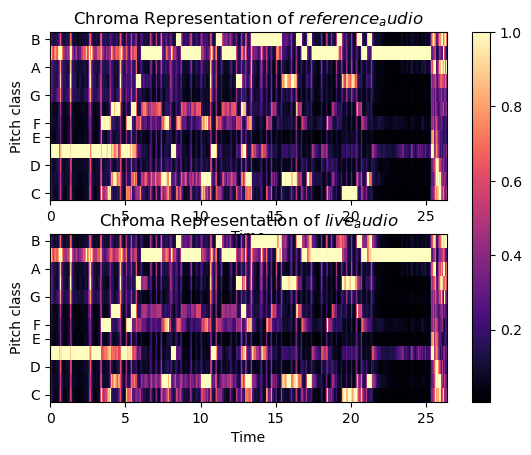

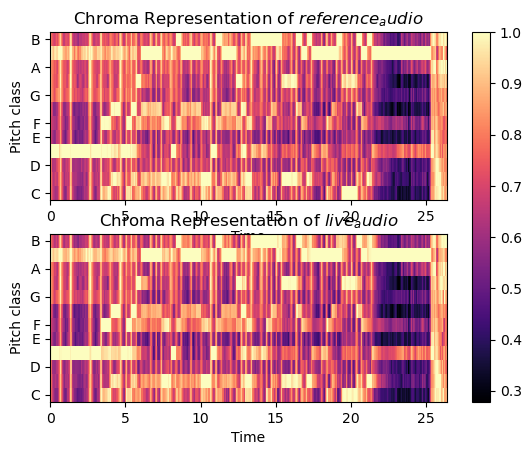

In [14]:
hop_length = 1024
min_frames = 5
alpha = 1

reference_audio_chroma = extract_chroma(reference_audio, sampling_rate, hop_length)
reference_audio_chroma_normalized = normalize_chroma_log(reference_audio_chroma)

live_audio_chroma = extract_chroma(live_audio, sampling_rate, hop_length)
live_audio_chroma_normalized = normalize_chroma_log(live_audio_chroma)

def plot_chroma(reference_chroma, live_chroma, hop_length):
    fig, ax = plt.subplots(nrows=2, sharey=True)
    img = librosa.display.specshow(reference_chroma, x_axis='time',
                                y_axis='chroma',
                                hop_length=hop_length, ax=ax[0])
    ax[0].set(title='Chroma Representation of $reference_audio$')
    librosa.display.specshow(live_chroma, x_axis='time',
                            y_axis='chroma',
                            hop_length=hop_length, ax=ax[1])
    ax[1].set(title='Chroma Representation of $live_audio$')
    fig.colorbar(img, ax=ax)
    plt.show()

plot_chroma(reference_audio_chroma, live_audio_chroma, hop_length)
plot_chroma(reference_audio_chroma_normalized, live_audio_chroma_normalized, hop_length)


# DTW

6.623470879417497


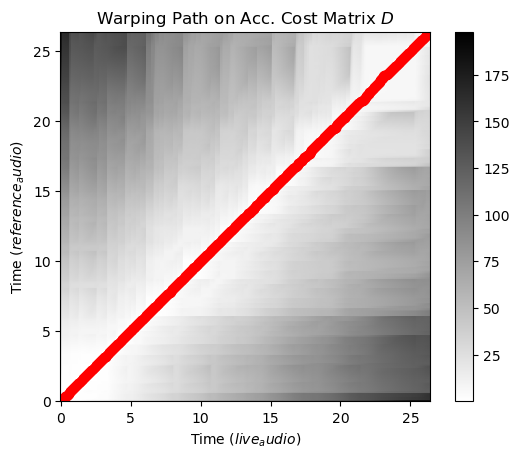

In [15]:
D, wp = librosa.sequence.dtw(X=reference_audio_chroma, Y=live_audio_chroma, metric='cosine')
wp_s = librosa.frames_to_time(wp, sr=sampling_rate, hop_length=hop_length)
print(D[-1, -1])

fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='time', sr=sampling_rate,
                               cmap='gray_r', hop_length=hop_length, ax=ax)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Acc. Cost Matrix $D$',
       xlabel='Time $(live_audio)$', ylabel='Time $(reference_audio)$')
fig.colorbar(img, ax=ax)

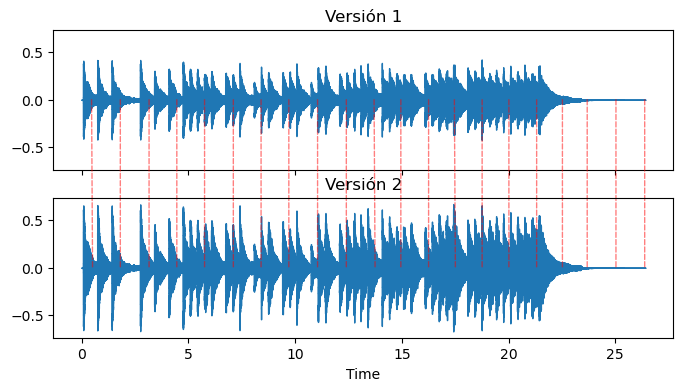

In [16]:
from matplotlib.patches import ConnectionPatch

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,4))

# Plot live_audio
librosa.display.waveshow(live_audio, sr=sampling_rate, ax=ax2)
ax2.set(title='Versión 2')

# Plot reference_audio
librosa.display.waveshow(reference_audio, sr=sampling_rate, ax=ax1)
ax1.set(title='Versión 1')
ax1.label_outer()


n_arrows = 20
for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='--',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)

# The Beat Spectrum

In [17]:
from scipy.spatial.distance import cdist

# Paso 1: Calcular el espectrograma o MFCC (representación del contenido)
def extract_features(audio, sampling_rate, hop_length=512, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = librosa.util.normalize(mfcc, axis=1)
    return mfcc.T  # frames x features

# Paso 2: Calcular matriz de autosemejanza
def compute_self_similarity_matrix(features):
    # Usa distancia coseno para medir la semejanza
    D = cdist(features, features, metric='cosine')
    S = 1 - D  # Convertimos distancia en similitud (1: iguales, 0: ortogonales)
    return S

# Paso 3: Calcular el beat spectrum
def compute_beat_spectrum(S):
    n = S.shape[0]
    beat_spectrum = np.array([
        np.mean(np.diag(S, k=lag)) for lag in range(1, n)
    ])
    return beat_spectrum

# Paso 4: Visualizar
def plot_beat_spectrum(beat_spectrum, sr, hop_length):
    times = np.arange(1, len(beat_spectrum) + 1) * hop_length / sr
    plt.figure(figsize=(10, 4))
    plt.plot(times, beat_spectrum)
    plt.xlabel("Time Lag (s)")
    plt.ylabel("Similarity")
    plt.title("Beat Spectrum")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

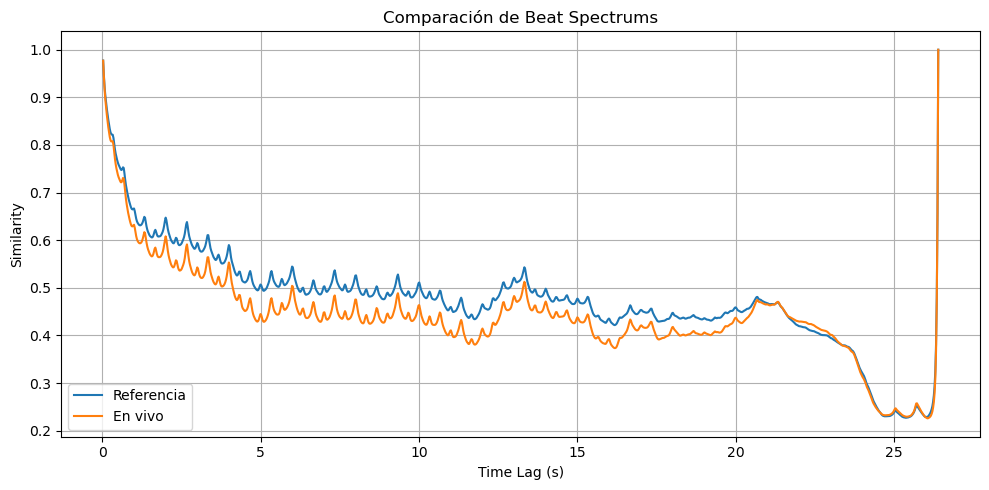

In [18]:
# Parámetros
hop_length = 512

# Referencia
ref_feat = extract_features(reference_audio, sampling_rate, hop_length)
S_ref = compute_self_similarity_matrix(ref_feat)
beat_ref = compute_beat_spectrum(S_ref)

# En vivo
live_feat = extract_features(live_audio, sampling_rate, hop_length)
S_live = compute_self_similarity_matrix(live_feat)
beat_live = compute_beat_spectrum(S_live)

# Ploteo comparado
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(beat_ref)+1) * hop_length / sampling_rate, beat_ref, label="Referencia")
plt.plot(np.arange(1, len(beat_live)+1) * hop_length / sampling_rate, beat_live, label="En vivo")
plt.xlabel("Time Lag (s)")
plt.ylabel("Similarity")
plt.title("Comparación de Beat Spectrums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


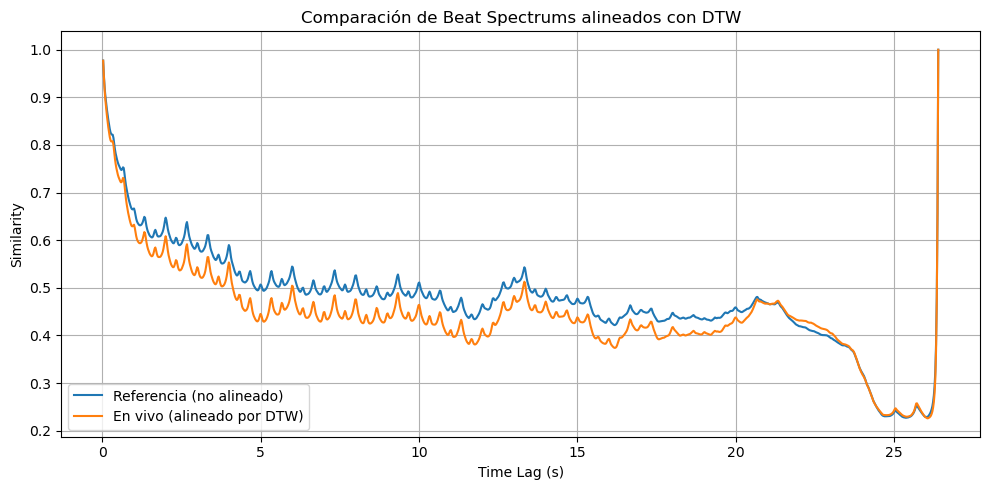

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.spatial.distance import cdist

# === Parámetros ===
hop_length = 512
n_mfcc = 20

reference_path = 'audio/01-reference.mp3'
live_path = 'audio/01-live.mp3'

reference_audio, sampling_rate = librosa.load(reference_path)
live_audio, sampling_rate = librosa.load(live_path)

# === Funciones ===
def extract_features(audio, sr, hop_length=512, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
    return librosa.util.normalize(mfcc, axis=1).T  # (frames, features)

def compute_self_similarity_matrix(features):
    D = cdist(features, features, metric='cosine')
    S = 1 - D
    return S

def compute_beat_spectrum(S):
    n = S.shape[0]
    return np.array([np.mean(np.diag(S, k=lag)) for lag in range(1, n)])

# === Cargar características ===
ref_feat = extract_features(reference_audio, sampling_rate, hop_length)
live_feat = extract_features(live_audio, sampling_rate, hop_length)

# === DTW para alinear ===
D, wp = librosa.sequence.dtw(X=ref_feat.T, Y=live_feat.T, metric='cosine')
wp = np.array(wp[::-1])  # Asegura que va de principio a fin

# === Aplicar alineamiento a live_feat ===
aligned_live_feat = np.zeros_like(ref_feat)
for i, (ref_idx, live_idx) in enumerate(wp):
    if ref_idx < len(aligned_live_feat) and live_idx < len(live_feat):
        aligned_live_feat[ref_idx] = live_feat[live_idx]

# === Calcular matrices de autosemejanza ===
S_ref = compute_self_similarity_matrix(ref_feat)
S_aligned = compute_self_similarity_matrix(aligned_live_feat)

# === Beat spectrums ===
beat_ref = compute_beat_spectrum(S_ref)
beat_aligned = compute_beat_spectrum(S_aligned)

# === Visualización comparativa ===
times = np.arange(1, len(beat_ref) + 1) * hop_length / sampling_rate

plt.figure(figsize=(10, 5))
plt.plot(times, beat_ref, label='Referencia (no alineado)')
plt.plot(times, beat_aligned, label='En vivo (alineado por DTW)')
plt.xlabel("Time Lag (s)")
plt.ylabel("Similarity")
plt.title("Comparación de Beat Spectrums alineados con DTW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


tabla de valores y diferencias entre los beats

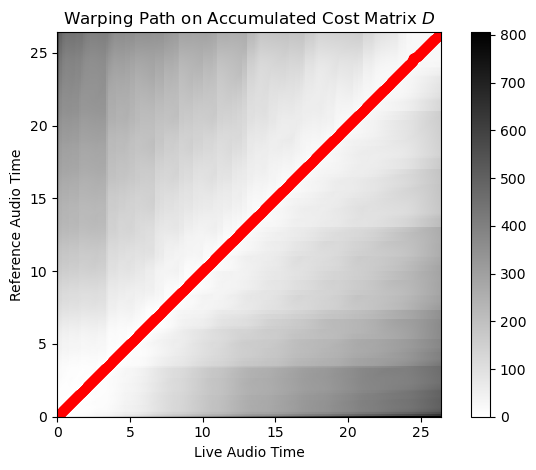

In [20]:
wp_s = librosa.frames_to_time(wp, sr=sampling_rate, hop_length=hop_length)

fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='time', sr=sampling_rate,
                               cmap='gray_r', hop_length=hop_length, ax=ax)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Accumulated Cost Matrix $D$',
       xlabel='Live Audio Time', ylabel='Reference Audio Time')
fig.colorbar(img, ax=ax)
plt.tight_layout()
plt.show()


In [21]:
# Listen to reference (blue)
print("Reference recording:")
Audio(data=reference_audio, rate=sampling_rate)

Reference recording:


In [22]:
# Listen to reference (orange)
print("Live recording:")
Audio(data=live_audio, rate=sampling_rate)

Live recording:


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import sounddevice as sd
import time
from scipy.spatial.distance import cdist

In [24]:
# !conda install -c conda-forge ipympl

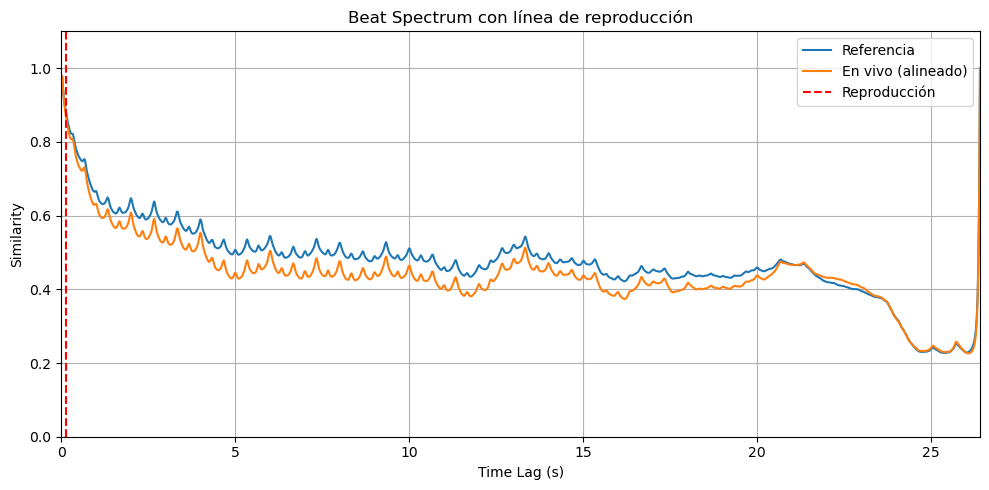

In [25]:
# === Parámetros ===
hop_length = 512
n_mfcc = 20

# === Funciones ===
def extract_features(audio, sr, hop_length=512, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
    return librosa.util.normalize(mfcc, axis=1).T  # (frames, features)

def compute_self_similarity_matrix(features):
    D = cdist(features, features, metric='cosine')
    S = 1 - D
    return S

def compute_beat_spectrum(S):
    n = S.shape[0]
    return np.array([np.mean(np.diag(S, k=lag)) for lag in range(1, n)])

# === Extraer características ===
ref_feat = extract_features(reference_audio, sampling_rate, hop_length)
live_feat = extract_features(live_audio, sampling_rate, hop_length)

# === Alinear con DTW ===
D, wp = librosa.sequence.dtw(X=ref_feat.T, Y=live_feat.T, metric='cosine')
wp = np.array(wp[::-1])

aligned_live_feat = np.zeros_like(ref_feat)
for ref_idx, live_idx in wp:
    if ref_idx < len(aligned_live_feat) and live_idx < len(live_feat):
        aligned_live_feat[ref_idx] = live_feat[live_idx]

# === Calcular beat spectrum ===
S_ref = compute_self_similarity_matrix(ref_feat)
S_aligned = compute_self_similarity_matrix(aligned_live_feat)

beat_ref = compute_beat_spectrum(S_ref)
beat_aligned = compute_beat_spectrum(S_aligned)

# === Tiempos ===
times = np.arange(1, len(beat_ref) + 1) * hop_length / sampling_rate
duration = librosa.get_duration(y=reference_audio, sr=sampling_rate)

# === Visualización interactiva ===
plt.ion()  # Modo interactivo ON

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times, beat_ref, label="Referencia")
ax.plot(times, beat_aligned, label="En vivo (alineado)")
progress_line = ax.axvline(0, color='red', linestyle='--', label="Reproducción")

ax.set_xlim(0, times[-1])
ax.set_ylim(0, max(np.max(beat_ref), np.max(beat_aligned)) * 1.1)
ax.set_xlabel("Time Lag (s)")
ax.set_ylabel("Similarity")
ax.set_title("Beat Spectrum con línea de reproducción")
ax.legend()
ax.grid(True)
plt.tight_layout()

# === Iniciar reproducción del audio ===
start_time = time.time()
sd.play(reference_audio, samplerate=sampling_rate)

# === Animación sincronizada ===
while True:
    elapsed = time.time() - start_time
    if elapsed > duration:
        break
    progress_line.set_xdata([elapsed])
    plt.pause(0.01)

# Esperar fin de audio (por si hay un pequeño desfase)
sd.wait()
plt.ioff()
plt.show()
